<a href="https://colab.research.google.com/github/xvoulis/TestCode2001/blob/main/IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Σύστημα Πρόληψης Εισβολών (IPS) χρησιμοποιώντας Python και το σύνολο δεδομένων `pcap_data.csv`.
Προσαρμογή του IDS ώστε να περιλαμβάνει προληπτικές ενέργειες βάσει ανιχνευμένων απειλών.
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [2]:
# Διεύθυνση συνόλου δεδομένων
DATASET_URL = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv'

In [13]:
# Load Dataset
def load_dataset():
    print("Loading dataset...")
    data = pd.read_csv(DATASET_URL)

    # Select features and target
    X = data.iloc[:, :-1]  # All columns except the last as features
    y = data.iloc[:, -1]   # Last column as the target

    # Encode target labels (Normal=0, Anomaly=1, Attack=2)
    # Handle unknown values by replacing them with a specific label or dropping them
    y = y.map({"Normal": 0, "Anomaly": 1, "Attack": 2}).fillna(0) # Replace NaN with 0
    # Alternatively, drop rows with unknown labels
    # data = data[data.iloc[:, -1].isin(["Normal", "Anomaly", "Attack"])]
    # X = data.iloc[:, :-1]
    # y = data.iloc[:, -1].map({"Normal": 0, "Anomaly": 1, "Attack": 2})


    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
# Κατασκευή του μοντέλου
def build_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # Επίπεδο εξόδου για 3 κατηγορίες
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Προληπτική δράση βάσει προβλέψεων
def take_preventive_action(predictions, X_test, y_test):
    actions = []
    for i, prediction in enumerate(predictions):
        if prediction == 1:  # Εντοπίστηκε ανωμαλία
            actions.append(f"ΕΙΔΟΠΟΙΗΣΗ: Εντοπίστηκε ανωμαλία για το δείγμα {i}. Ειδοποίηση διαχειριστών.")
        elif prediction == 2:  # Εντοπίστηκε επίθεση
            actions.append(f"ΑΠΟΚΛΕΙΣΜΟΣ: Εντοπίστηκε επίθεση για το δείγμα {i}. Αποκλεισμός ύποπτης κυκλοφορίας.")
        else:  # Κανονική κυκλοφορία
            actions.append(f"ΕΠΙΤΡΕΠΕΤΑΙ: Κανονική κυκλοφορία για το δείγμα {i}.")

    # Εμφάνιση ή καταγραφή ενεργειών
    for action in actions:
        print(action)

In [16]:
#Κύριο σενάριο
# Main Script
def main():
    X_train, X_val, X_test, y_train, y_val, y_test = load_dataset()
    input_shape = X_train.shape[1]

    # Build the model
    model = build_model(input_shape)
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=256,
        callbacks=[early_stopping, model_checkpoint]
    )
    return model, history, X_test, y_test
if __name__=='__main__':
    model, history, X_test, y_test = main()

Loading dataset...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,003 (187.51 KB)

 Trainable params: 48,003 (187.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9387 - loss: 0.2877 - val_accuracy: 1.0000 - val_loss: 2.5720e-05
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0569e-05 - val_accuracy: 1.0000 - val_loss: 1.3472e-05
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.7147e-05 - val_accuracy: 1.0000 - val_loss: 1.2396e-05
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.2681e-05 - val_accuracy: 1.0000 - val_loss: 1.1461e-05
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.3873e-05 - val_accuracy: 1.0000 - val_loss: 1.0505e-05
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.2117e-05 - val_accuracy: 1.0000 - val_loss: 9.5633e-06
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9756e-05 - val_accuracy: 1.0000 - val_loss: 8.7179e-06
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0

In [18]:
# Evaluate the model
print("\nEvaluating the model on test data...")
test_loss, test_accuracy = model.evaluate(X_test, y_test) # Changed test_accurary to test_accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Evaluating the model on test data...
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 5.9210e-07
Test Loss: 5.195582275518973e-07
Test Accuracy: 1.0


In [20]:
# Predictions and Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2246

    accuracy                           1.00      2246
   macro avg       1.00      1.00      1.00      2246
weighted avg       1.00      1.00      1.00      2246


Confusion Matrix:
[[2246]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


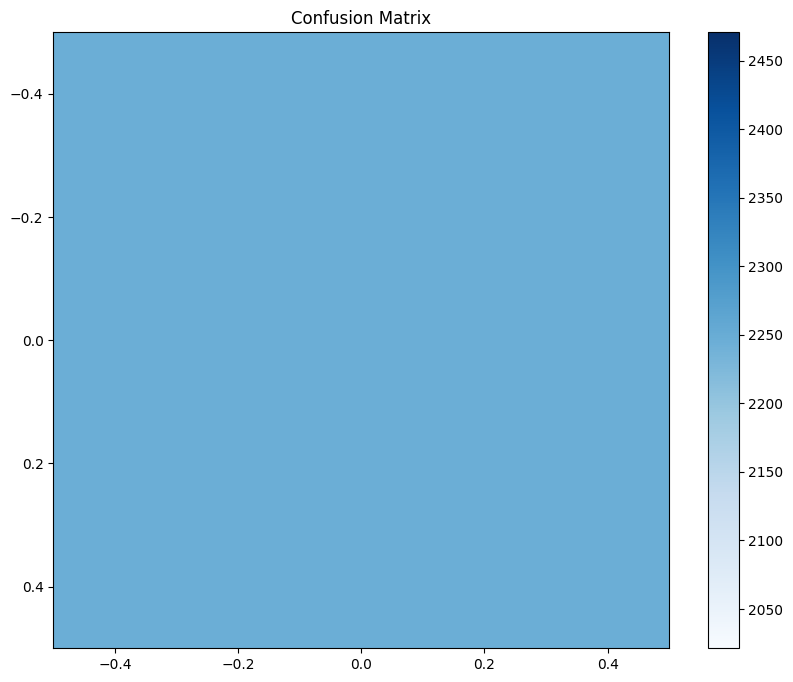

In [22]:
 # Plot Confusion Matrix
plt.figure(figsize=(10, 8))
plt.title('Confusion Matrix')
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.show()

Loading dataset...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,003 (187.51 KB)

 Trainable params: 48,003 (187.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8726 - loss: 0.3908 - val_accuracy: 1.0000 - val_loss: 9.8564e-05
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.1228e-04 - val_accuracy: 1.0000 - val_loss: 4.7630e-05
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.0327e-05 - val_accuracy: 1.0000 - val_loss: 4.0963e-05
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.8955e-05 - val_accuracy: 1.0000 - val_loss: 3.5069e-05
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4733e-05 - val_accuracy: 1.0000 - val_loss: 2.9961e-05
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 6.0854e-05 - val_accuracy: 1.0000 - val_loss: 2.5490e-05
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0035e-05 - val_accuracy: 1.0000 - val_loss: 2.1844e-05
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0

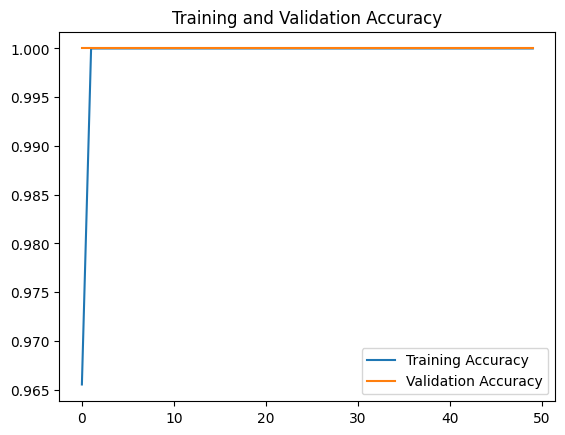

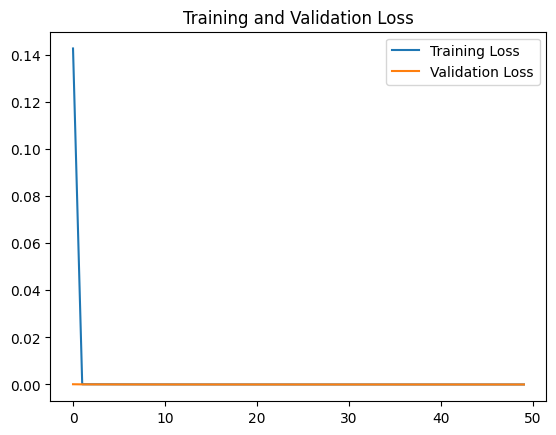

In [23]:
# Plot Training History

def plot_training_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    model, history, X_test, y_test = main()
    plot_training_history(history) # Calling the function after main function call